# Basics of Deep Learning

In [99]:
student_id = 400101861 #@param {type:"integer"}
student_name = "ahmadreza majlesara" #@param {type:"string"}

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook).

In [100]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# TODO: Enter the foldername in your Drive where you have saved the
# assignment files, e.g. 'DL/assignments/assignment1/'
FOLDERNAME = "DL/assignments/assignment1"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

The dataset for this exercise is CIFAR-10. Let's first download it then we'll explore it.

In [102]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/DL/assignments/assignment1/datasets
/content/drive/My Drive/DL/assignments/assignment1


In [103]:
import os
import pytz
from datetime import datetime

# The file path
GOOGLE_DRIVE_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
pytorch_path = os.path.join(GOOGLE_DRIVE_PATH, 'k_nearest_neighbor.py')

# Get the last modified time in UTC
last_modified_time = os.path.getmtime(pytorch_path)
utc_time = datetime.utcfromtimestamp(last_modified_time)

# Define Iran's time zone
iran_tz = pytz.timezone('Asia/Tehran')

# Convert UTC time to Iran time
iran_time = pytz.utc.localize(utc_time).astimezone(iran_tz)

# Print the result in Iran's local time
print(f"k_nearest_neighbor.py last edited on: {iran_time.strftime('%Y-%m-%d %H:%M:%S')}")

k_nearest_neighbor.py last edited on: 2024-10-27 21:47:09


# k-Nearest Neighbor (kNN)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

You will implement these steps in this notebook and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

The following code is to setup the enviroment

In [104]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# This is here so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

Clear previously loaded data.


In [106]:
################################################################################
# TODO:                                                                        #
# As a sanity check, print out the size of the training and test data and      #
# also the size of their labels                                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


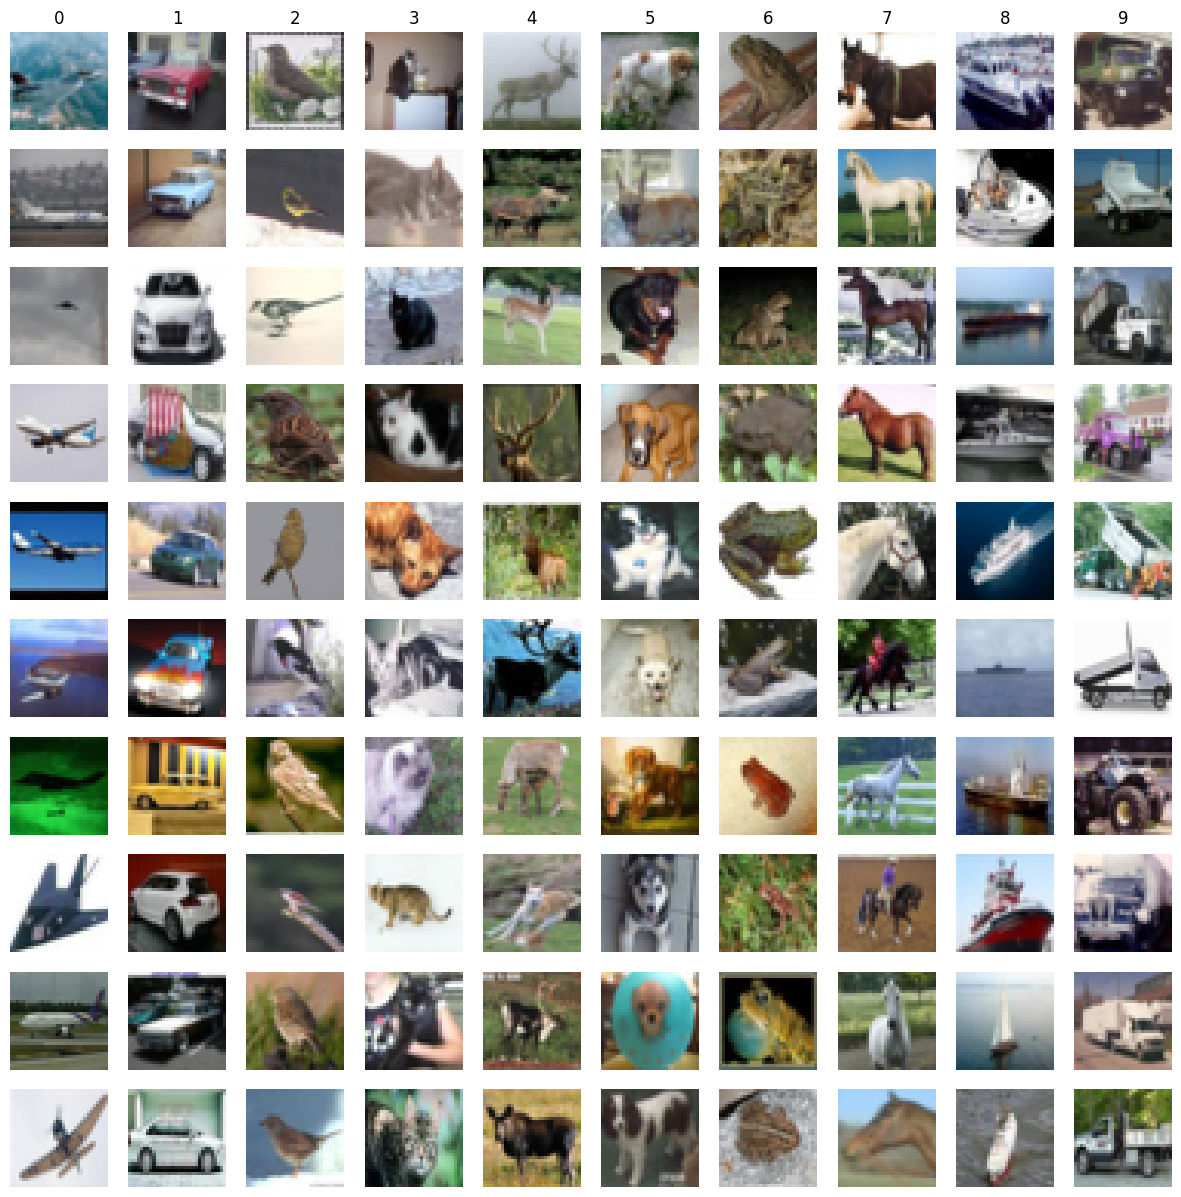

In [107]:
classes = np.unique(y_train)
num_classes = len(classes)
samples_per_class = 10

################################################################################
# TODO:                                                                        #
# Explore the dataset and find its classes. Then visualize some examples.      #
# To do so show a few examples of training images from each class              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
plt.figure(figsize=(15, 15))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        image = X_train[idx].reshape(32, 32, 3)
        plt.imshow(image.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [108]:
################################################################################
# TODO:                                                                        #
# Subsample the data for more efficient code execution in this exercise.       #
# You should reduce the number of training and test examples used.             #
# Set num_training to 5000 and num_test to 500.                                #
# Reshape the image data into rows to prepare for processing.                  #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Subsample the data
num_training = 5000
num_test = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

(5000, 3072) (500, 3072)
(5000,) (500,)


In [109]:
from k_nearest_neighbor import KNearestNeighbor

################################################################################
# TODO:                                                                        #
# Create a kNN classifier instance and call its training method.                #
# Remember that training a kNN classifier is a noop:                           #
# the classifier simply remembers the data and does no further processing.     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [110]:
# Open k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# TODO: Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


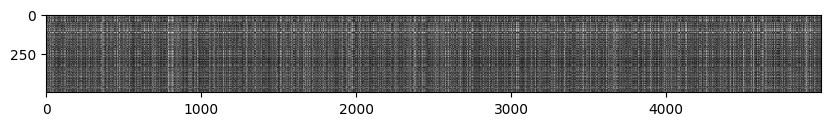

In [111]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{pink}{\textit Your Answer:}$

Bright Rows: These correspond to specific test samples that have higher distances from a large portion of the training samples. This may indicate that these test samples are quite different from most training samples in terms of features. They could be outliers or represent unique cases within the dataset that do not resemble the majority of training data.

Bright Columns: Similarly, bright columns suggest that certain training samples are far from many test samples, meaning that they are likely different in feature space compared to the majority of the test data. These could represent outliers or unique instances within the training set.



In [112]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# TODO: Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

137 / 500 were correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [113]:
# TODO: Do the same as before with k=5
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test

print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

139 / 500 were correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{pink}{\textit Your Answer:}$
1, 2, and 3


$\color{pink}{\textit Your Explanation:}$
For a Nearest Neighbor (NN) classifier using L1 distance, the classifier's performance depends on the ordering of distances between data points. Preprocessing steps that uniformly shift or scale the data without altering this ordering will not affect performance.

- **Option 1:** Subtracting the overall mean $\mu$ from all pixel values:

  $$
  \tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu
  $$

  The mean $\mu$ cancels out when computing the difference between any two images, so the L1 distances remain unchanged.

- **Option 2:** Subtracting the per-pixel mean $\mu_{ij}$:

  $$
  \tilde{p}_{ij}^{(k)} = p_{ij}^{(k)} - \mu_{ij}
  $$

  Similarly, $\mu_{ij}$ cancels out in the differences, leaving distances unaffected.

- **Option 3:** Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$:

  $$
  \tilde{p}_{ij}^{(k)} = \frac{p_{ij}^{(k)} - \mu}{\sigma}
  $$

  This scales all distances by a constant factor $ \frac{1}{\sigma} $, which does not change the ordering of distances.

- **Option 4:** Subtracting $\mu_{ij}$ and dividing by $\sigma_{ij}$:

  $$
  \tilde{p}_{ij}^{(k)} = \frac{p_{ij}^{(k)} - \mu_{ij}}{\sigma_{ij}}
  $$

  This applies different scaling to each pixel, altering the distances unevenly and potentially changing the classifier's performance.

- **Option 5:** Rotating the images changes the spatial arrangement of pixels, affecting the L1 distances and possibly the classifier's performance.



In [89]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [90]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


Explain how you have implemented compute_distances_no_loops

$\color{pink}{\textit Your Answer:}$

The compute_distances_no_loops function calculates the L2 distance between test points in X and training points in self.X_train without using explicit loops. It uses vectorized operations.
first it Compute squared sums of test points `X_squared` and training points `X_train_squared`.then Use the formula $\sqrt{x^2 + y^2 - 2xy}$ to compute the distance matrix dists.

In [91]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 39.224086 seconds
One loop version took 64.486507 seconds
No loop version took 0.764529 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [92]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

################################################################################
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    accuracies = []
    for i in range(num_folds):
        X_train_fold = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]

        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        y_pred = classifier.predict(X_val_fold, k=k)
        accuracy = np.mean(y_pred == y_val_fold)

        accuracies.append(accuracy)

        k_to_accuracies[k] = accuracies

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

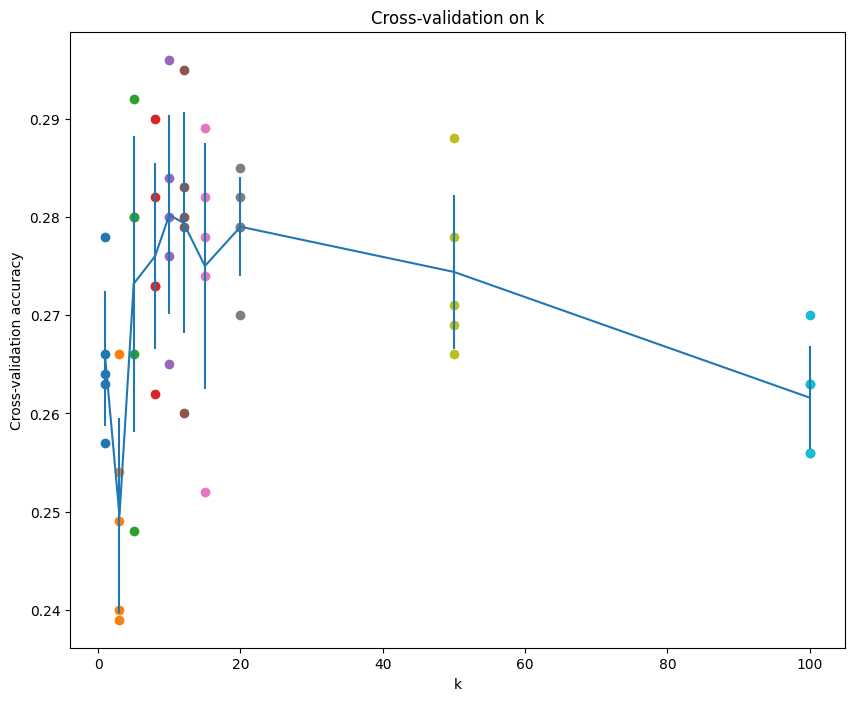

In [93]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [120]:
# TODO: Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = max(k_to_accuracies, key=lambda k: np.mean(k_to_accuracies[k]))
print('The best k is: ', best_k)

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

dists = classifier.compute_distances_no_loops(X_test)

y_test_pred = classifier.predict_labels(dists, k=best_k)

num_test = X_test.shape[0]
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test



print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

The best k is:  10
141 / 500 were correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{pink}{\textit Your Answer:}$

2 and 4

$\color{pink}{\textit Your Explanation:}$

- **Statement 1:** *The decision boundary of the $k$-NN classifier is linear.*

  This is **false**. The decision boundary of a $k$-NN classifier is generally non-linear and can be highly complex, especially in higher-dimensional spaces. It is shaped by the distribution of the training data and is not limited to linear separations.

- **Statement 2:** *The training error of a 1-NN will always be lower than or equal to that of 5-NN.*

  This is **true**. In 1-NN classification, each training example is classified based on its nearest neighbor, which is typically itself, leading to a training error of zero unless there are identical instances with different labels. In contrast, 5-NN considers the majority label among the 5 nearest neighbors, which may include examples from other classes, potentially increasing the training error.

- **Statement 3:** *The test error of a 1-NN will always be lower than that of a 5-NN.*

  This is **false**. While 1-NN may have a lower training error due to overfitting, it doesn't guarantee a lower test error. In practice, 5-NN often generalizes better to unseen data, potentially resulting in a lower test error compared to 1-NN.

- **Statement 4:** *The time needed to classify a test example with the $k$-NN classifier grows with the size of the training set.*

  This is **true**. Classifying a test example involves computing the distance between the test example and each training example. Therefore, the computational time increases linearly with the size of the training set.

- **Statement 5:** *None of the above.*

  This is **false** because statements 2 and 4 are true.
